# Feature Selection + Class Balancing

In [43]:
import kagglehub
import numpy as np
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("shrutimechlearn/churn-modelling", path="Churn_Modelling.csv")

df = pd.read_csv(path)

In [44]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [45]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Let's get rid of unuseful columns. 

In [46]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis=1)

## Explanatory Data Analysis

In [47]:
columns_for_plotting = df.select_dtypes(include=['int', 'float']).columns
columns_for_plotting

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

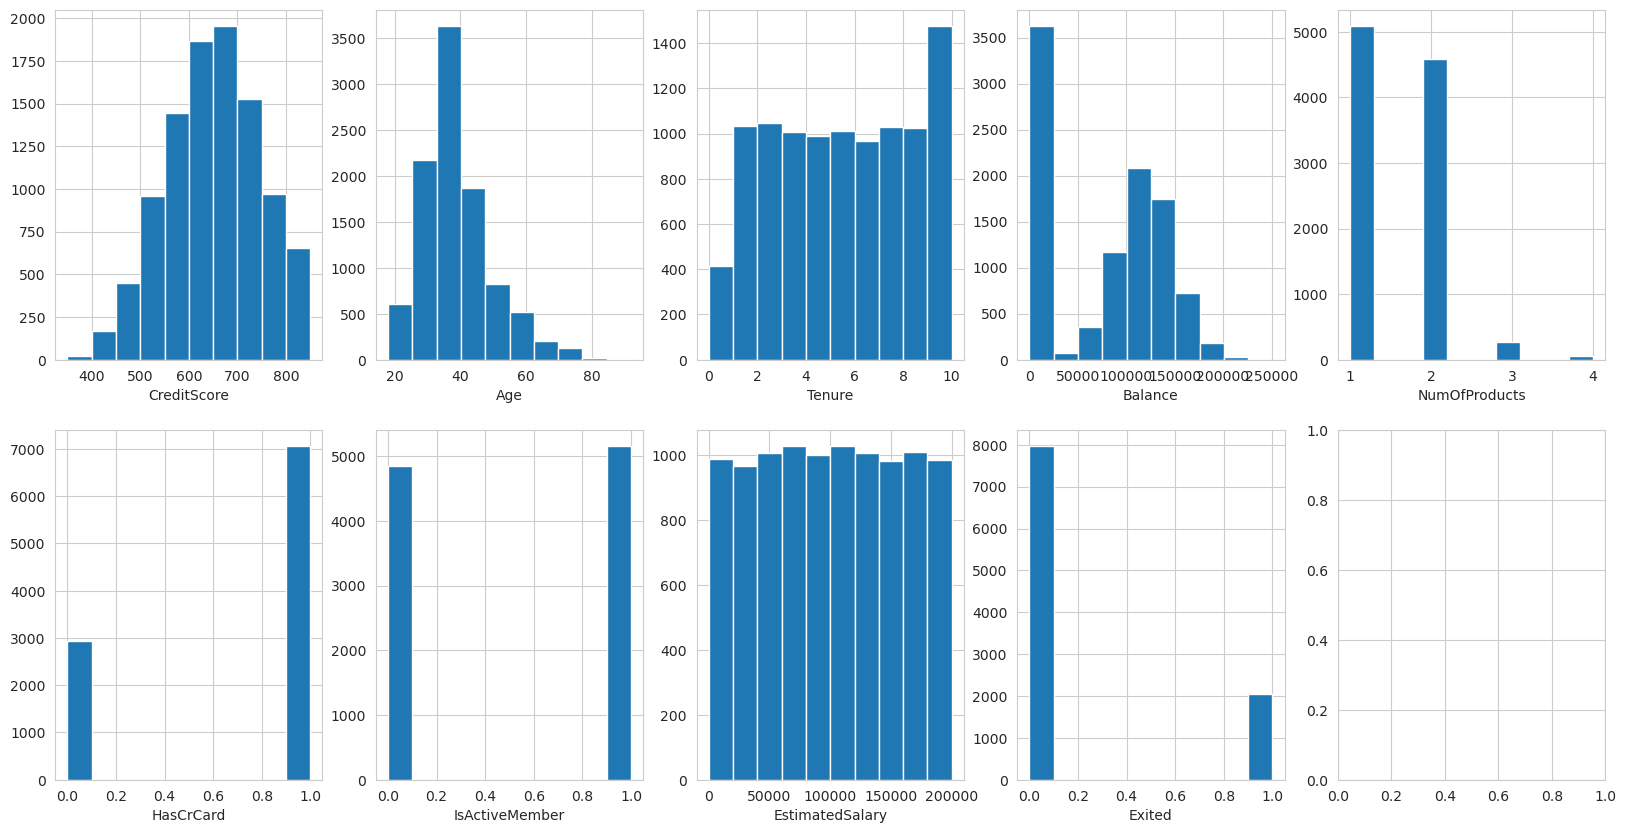

In [48]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, column in enumerate(columns_for_plotting):
    axs[i].hist(df[column])
    axs[i].set_xlabel(column)

Here we could observe some interesting graphs. **CreditScore** and **Age** are almost a normal distribution. Also, **Balance** have the same pattern with exception that has a big numbers of clients with 0 balance. Also, we could observe that **Existed** our target has unbalanced results which we will have to fix (minority class is - 0 and the majority - 1). 

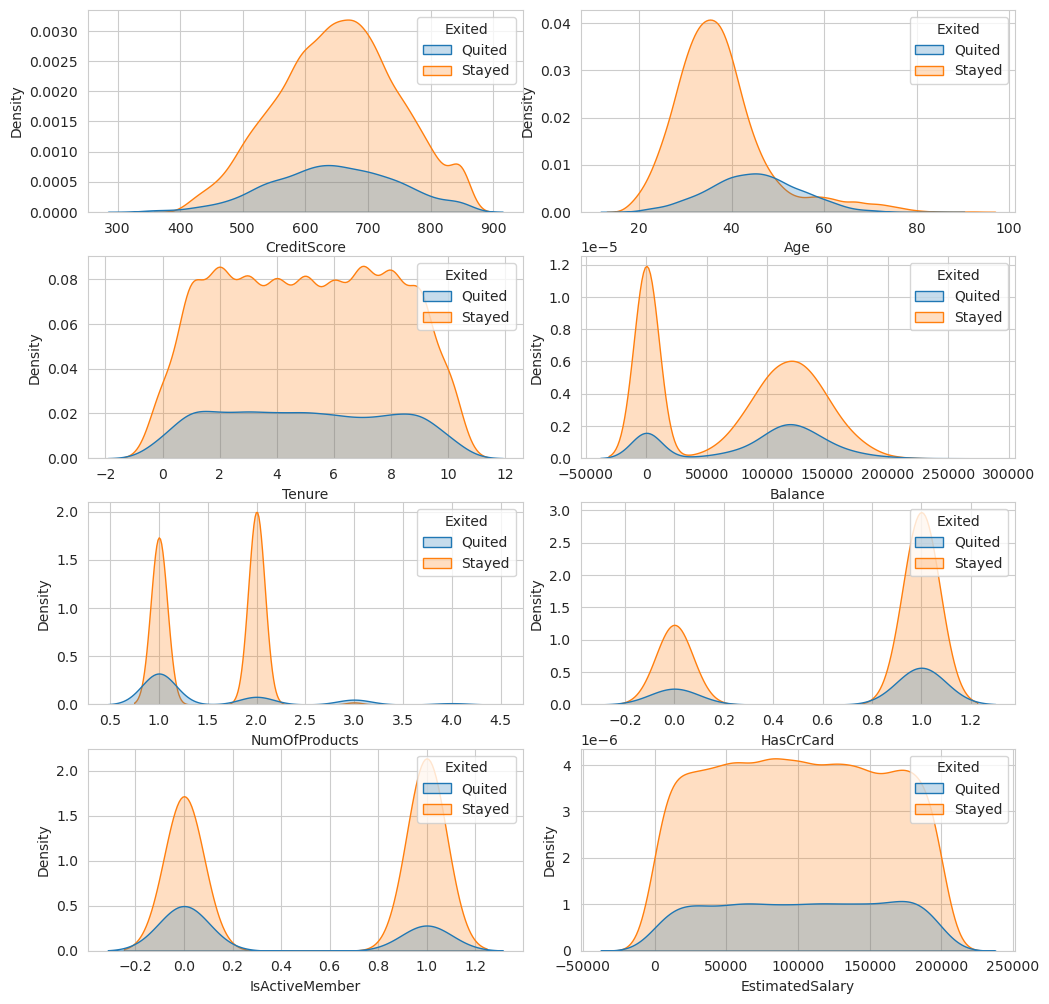

In [49]:
import seaborn as sns

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
fig.tight_layout() 

category = df.copy() 
category["Exited"] = category["Exited"].astype(str) # a warning raises if the 
category.loc[category["Exited"] == "1", "Exited"] = "Quited"
category.loc[category["Exited"] == "0", "Exited"]  = "Stayed"

axes = axes.flatten()
with sns.axes_style("whitegrid"):
    for i, column in enumerate(pd.DataFrame(columns=columns_for_plotting).drop('Exited', axis=1)):
        sns.kdeplot(category, x=column , hue="Exited", fill=True, ax = axes[i])

It is surprisingly how all charts show almost no difference that will indicate some clues for predicting the target column. Although there are some, for example we could see that clients that uses only one product tend to Quit bank. Also, could be observed that there are a tendency for people in ~45 to quit more often which indicates as that the Age will have the greatest correlation with the target.

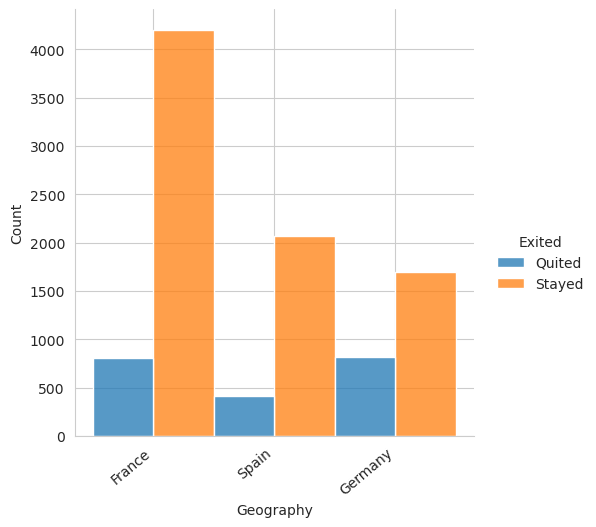

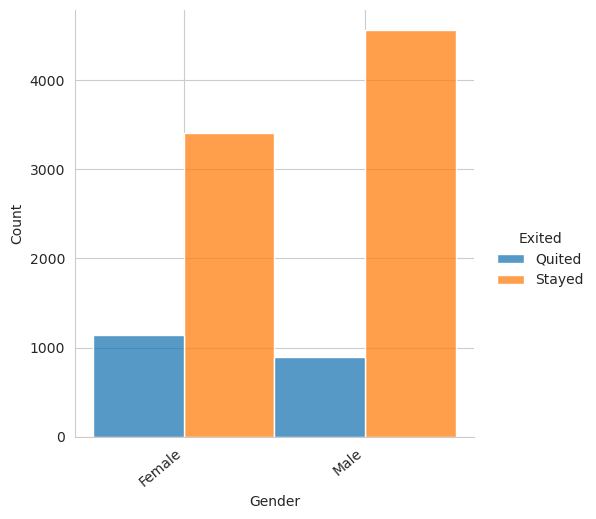

In [50]:
import seaborn as sns

category = df[['Geography', 'Gender', 'Exited']].copy() 
category["Exited"] = category["Exited"].astype(str) # a warning raises if the 
category.loc[category["Exited"] == "1", "Exited"] = "Quited"
category.loc[category["Exited"] == "0", "Exited"]  = "Stayed"

for i, column in enumerate(category.columns[:-1]):
    ax = sns.displot(category, x=column, hue="Exited", multiple="dodge", hue_order = ['Quited', 'Stayed'])
    ax.set_xticklabels(category[column].unique(),  rotation=40, ha="right")

Again there aren't any obvious indices to tell us that a specific category of people tend to quit the bank.

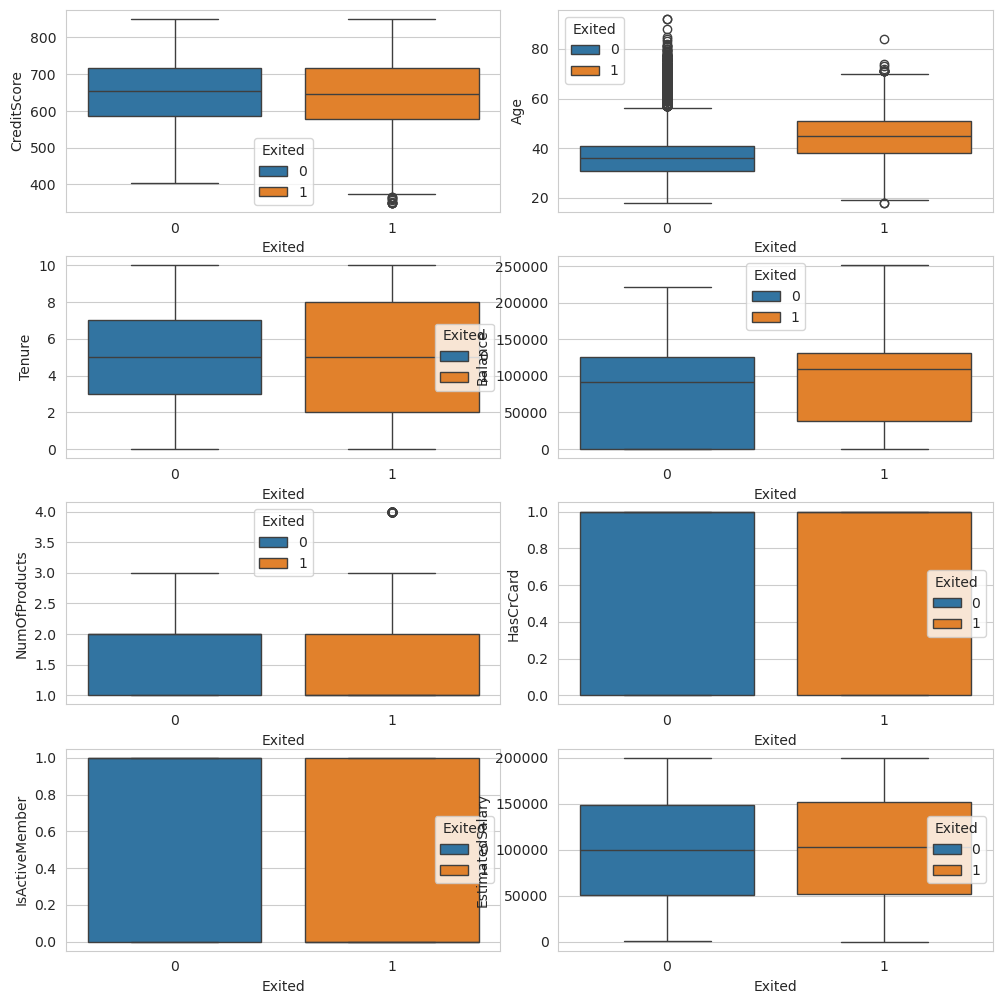

In [51]:
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
fig.tight_layout()

axes = axes.flatten()
for i, column in enumerate(columns_for_plotting[:-1]):
    sns.boxplot(x='Exited', y=column, data=df,  ax = axes[i], hue="Exited")

Here aren't many things to say I just wanted to determine if there are any outliers in the dataset and yes there are for **Age**. By they are few and this will need to be taken in consideration to set *contamination* to a lower value.

In [52]:
df = pd.get_dummies(df, columns=['Gender', 'Geography'], drop_first= True)

<Axes: >

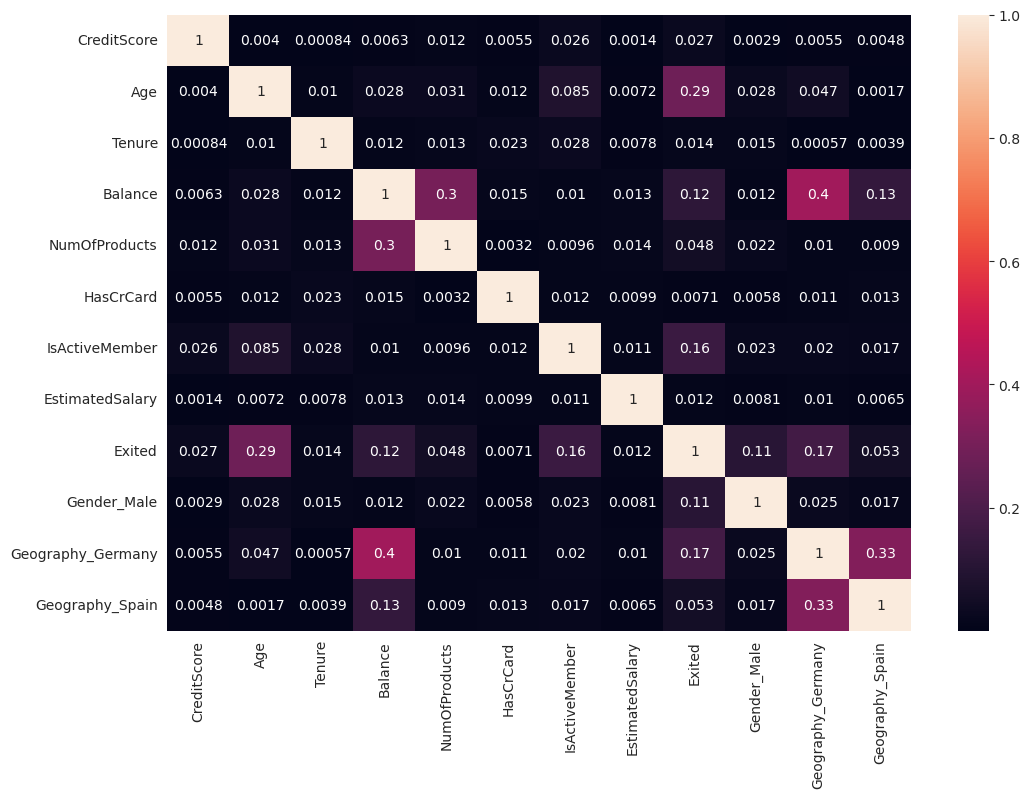

In [53]:
plt.figure(figsize=(12, 8))
plt.tight_layout()
sns.heatmap(abs(df.corr()), annot=True)

As mentioned earlier the **Age** has the greatest correlation. Also for some reason the second-biggest correlation is for Geography_Germany.

In [54]:
abs(df.corr()["Exited"]).sort_values()[::-1]

Exited               1.000000
Age                  0.285323
Geography_Germany    0.173488
IsActiveMember       0.156128
Balance              0.118533
Gender_Male          0.106512
Geography_Spain      0.052667
NumOfProducts        0.047820
CreditScore          0.027094
Tenure               0.014001
EstimatedSalary      0.012097
HasCrCard            0.007138
Name: Exited, dtype: float64

<Axes: >

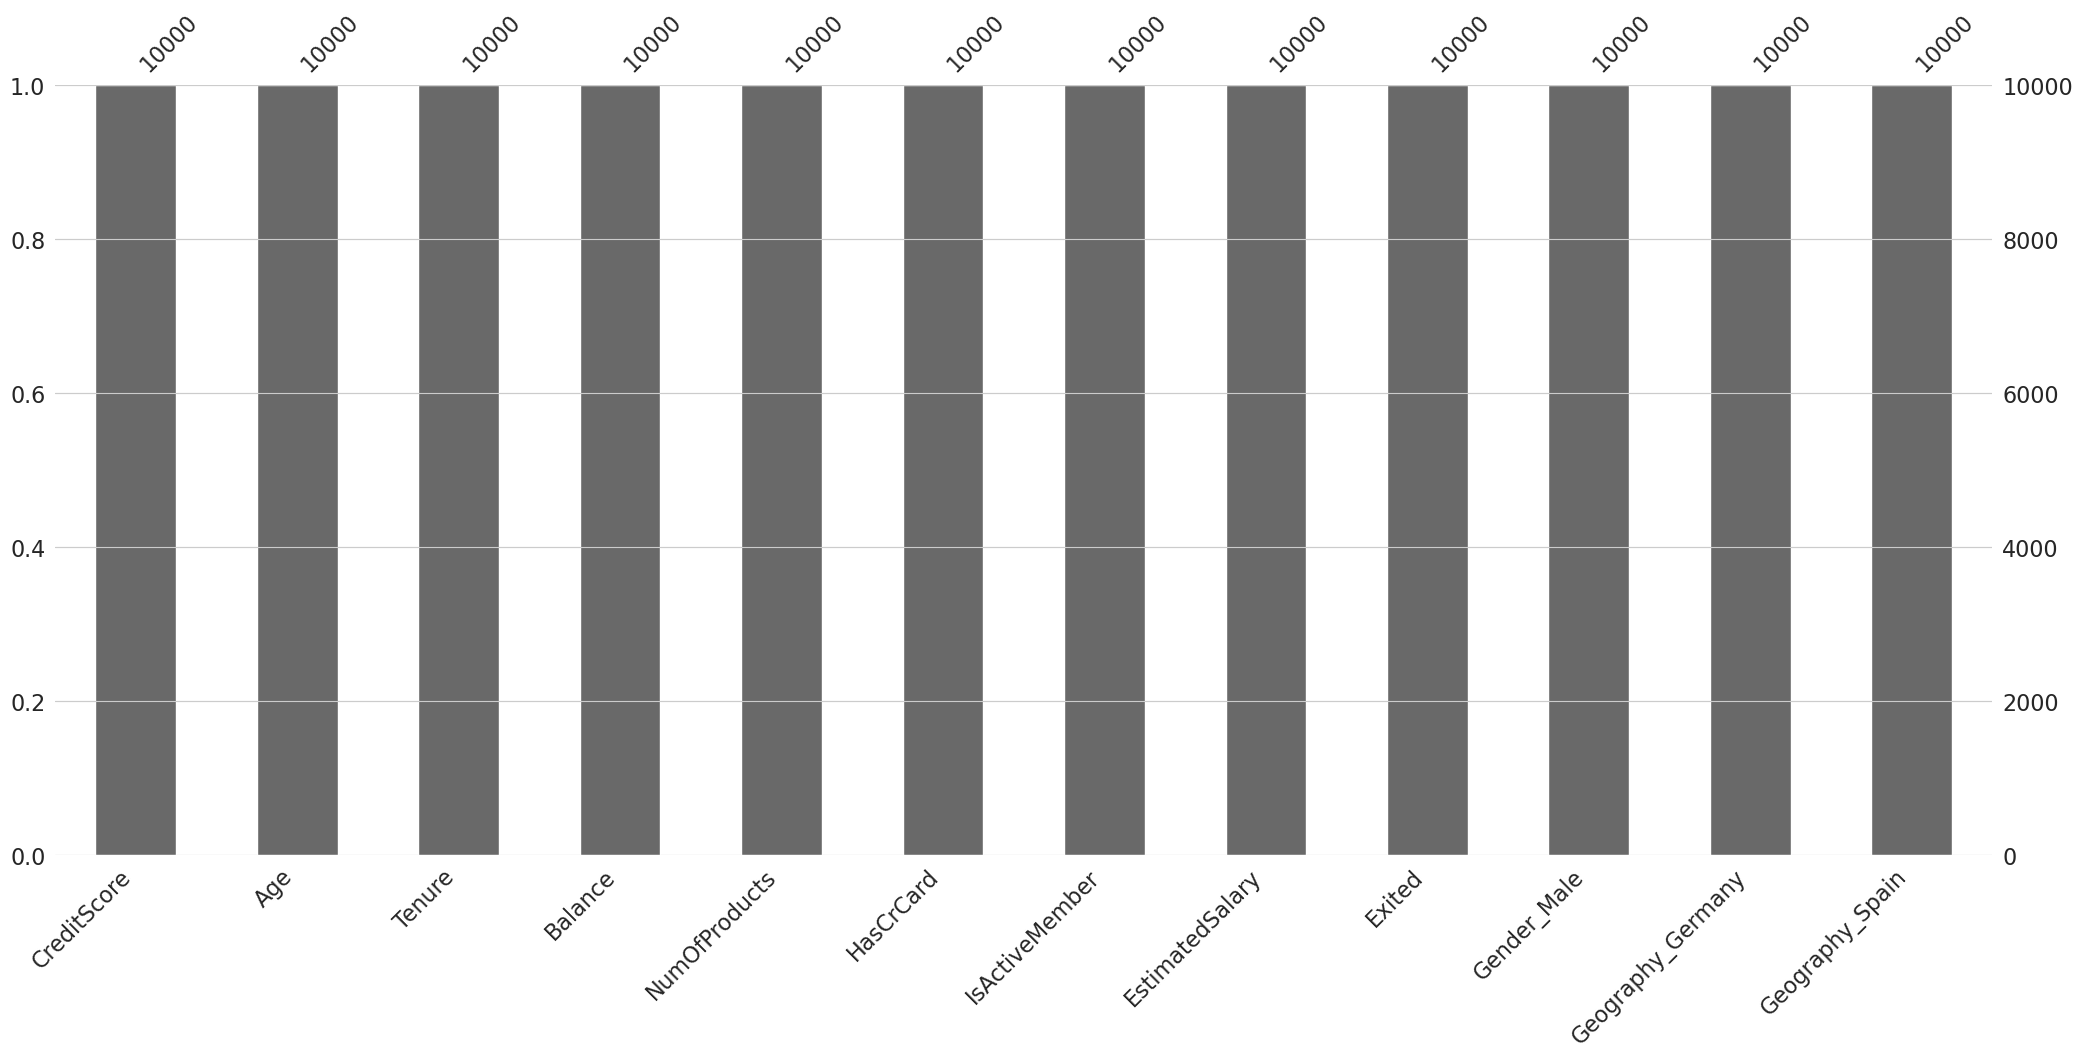

In [55]:
import missingno as msno
%matplotlib inline
msno.bar(df)

As could have seen this is a clean dataset and there aren't any missing values.

### Outliers

In [56]:
from sklearn.neighbors import LocalOutlierFactor
model=LocalOutlierFactor(contamination=0.01)

df['outlier']=pd.Series(model.fit_predict(df.values))
outliers_counters = df["outlier"].value_counts()
df=df[df.outlier!=-1]
df.drop(['outlier'], axis=1, inplace=True)

In [57]:
outliers_counters

outlier
 1    9900
-1     100
Name: count, dtype: int64

### Feature Selection
I will apply mainly to types of selection by Spearman Correlation and PointBiserialCorr.

#### Spearman Coreelation 

In [58]:
correlation_columns = ['pearson', 'kendall', 'spearman']
correlation_dataframe = pd.DataFrame({}, columns=correlation_columns)

for corr_method in correlation_columns:
    correlation_dataframe[corr_method] = abs(df.corr(method=corr_method)["Exited"]).sort_values()[::-1]

correlation_dataframe

,pearson,kendall,spearman
Exited,1.000000,1.000000,1.000000
Age,0.285855,0.268808,0.324255
Geography_Germany,0.179168,0.179168,0.179168
IsActiveMember,0.156527,0.156527,0.156527
Balance,0.115441,0.092424,0.108089
Gender_Male,0.105163,0.105163,0.105163
Geography_Spain,0.055636,0.055636,0.055636
NumOfProducts,0.045679,0.121632,0.123460
CreditScore,0.029113,0.020691,0.025298
Tenure,0.014642,0.012497,0.014621


Firstly we could observe that the features have a low correlation factor. The best correlation factor are given by the *spearman* correlation. That's why it would be used for feature correlation. Also, will lower the *min_corr* to 0.1 because otherwise it will not include anything.

In [59]:
from kydavra import SpearmanCorrelationSelector
spearman = SpearmanCorrelationSelector(min_corr=0.1)
selected_columns_spearman = spearman.select(df, 'Exited')

In [60]:
selected_columns_spearman

['Age',
 'Balance',
 'NumOfProducts',
 'IsActiveMember',
 'Geography_Germany',
 'Geography_Spain']

#### Point-Biserial Feature

In [61]:
from kydavra import PointBiserialCorrSelector
point_biserial = PointBiserialCorrSelector()
selected_column_point = point_biserial.select(df, 'Exited')

In [62]:
selected_column_point

['Age', 'Balance', 'IsActiveMember']

### Class Balancing

In [63]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, random_state=197, test_size=0.3)

In [64]:
from crucio import SMOTE

smote = SMOTE()
balanced_df = smote.balance(train_df, 'Exited')
balanced_df.shape

(11080, 12)

As you could observe the nr of values increased significantly. 

## Training

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

classifiers = [LogisticRegression(), SVC(), RandomForestClassifier(), GaussianNB()]

y_train = balanced_df['Exited']
x_train = balanced_df.drop('Exited', axis=1)
y_test = test_df['Exited']
x_test = test_df.drop('Exited', axis=1)

columns_for_applying_scaling = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

min_max_scaler = MinMaxScaler()
x_train[columns_for_applying_scaling] = min_max_scaler.fit_transform(x_train[columns_for_applying_scaling])
x_test[columns_for_applying_scaling] = min_max_scaler.transform(x_test[columns_for_applying_scaling])

standard_scaler = StandardScaler()
x_train[columns_for_applying_scaling] = standard_scaler.fit_transform(x_train[columns_for_applying_scaling])
x_test[columns_for_applying_scaling] = standard_scaler.transform(x_test[columns_for_applying_scaling])

classifiers_score =  []
for selection_method, features in {"spearman":selected_columns_spearman, "point":selected_column_point}.items():
    for classifier in classifiers:
        classifier.fit(x_train[features], y_train)
        predictions = classifier.predict(x_test[features])
        
        accuracy = accuracy_score(y_test, predictions)
        classifiers_score.append([selection_method,classifier.__class__.__name__, accuracy])

pd.DataFrame(classifiers_score, columns=['Future Selection Method','Model', 'Accuracy'])

,Future Selection Method,Model,Accuracy
0,spearman,LogisticRegression,0.700000
1,spearman,SVC,0.833670
2,spearman,RandomForestClassifier,0.841077
3,spearman,GaussianNB,0.710438
4,point,LogisticRegression,0.690909
5,point,SVC,0.782492
6,point,RandomForestClassifier,0.776768
7,point,GaussianNB,0.696633


As we can see the greatest accuracy we have with RandomForestClassifier with Feature Selection Method to be SpearmanSelector.

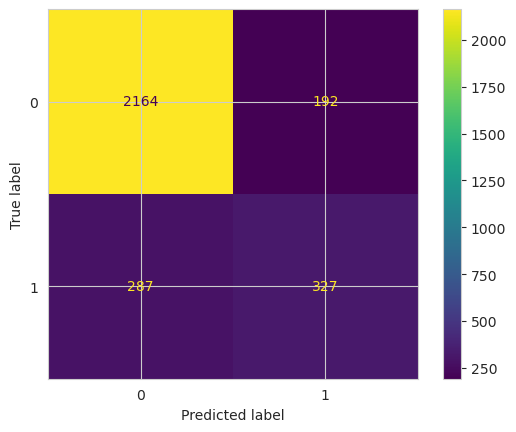

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = RandomForestClassifier()
clf.fit(x_train[selected_columns_spearman], y_train)
predictions = clf.predict(x_test[selected_columns_spearman])

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)

disp.plot()

Let's see if we can improve this results by hyperparathyroidism.

In [73]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(n_estimators=range(1,100), criterion=['gini', 'entropy', 'log_loss'])
searchCV = RandomizedSearchCV(clf, distributions, random_state=0)
search = searchCV.fit(x_train[selected_columns_spearman], y_train)
search.best_params_

{'n_estimators': 17, 'criterion': 'log_loss'}

0.8397306397306398


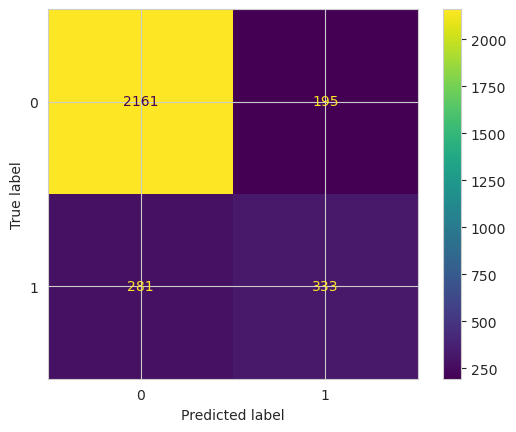

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = RandomForestClassifier(**search.best_params_)
clf.fit(x_train[selected_columns_spearman], y_train)
predictions = clf.predict(x_test[selected_columns_spearman])

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
print(accuracy_score(y_test, predictions))

disp.plot()

Yeah, as we could have seen there isn't much increase.

## Conclusion

As a conclusion we applied the basics procedure for the Churn Modelling. We started EDA and predicted that will have a very confusing model because of the data that are almost similar. During the process of feature selection we again confirmed that the features have a low correlation. Then we applied basic preprocessing techniques like class balancing, dummy variables, and scalers. In the end we got a model with the accuracy of 0.837 which is RandomForestClassifier. We accomplished our initial goal to apply class balancing and Feature Selection and even compared the accuracy of two selection methods.